<a href="https://colab.research.google.com/github/kairosilveira/kairo_katia_git/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with DistilBERT

## Introduction

This project focuses on text classification using the DistilBERT model from the Hugging Face library. DistilBERT is a distilled version of the BERT model, offering similar performance with faster inference times and reduced memory requirements. The objective is to explore various aspects of the Hugging Face library and transformers, including tokenization, embeddings, encoder, and hidden states, to fine-tune the DistilBERT model for a specific text classification task.

## Objectives

1. **Model Selection**: Utilize the DistilBERT model (`distilbert-base-uncased`) from the Hugging Face model hub.
2. **Tokenization and Embeddings**: Explore the tokenizer provided by the Hugging Face library and understand the process of converting text into input features for the model.
3. **Encoder and Hidden States**: Dive into the architecture of the DistilBERT model, including its encoder layers and hidden states.
4. **Fine-Tuning**: Fine-tune the pre-trained DistilBERT model with a classification head specific to the problem domain.
5. **Inspiration**: This project is inspired by Chapter Two of the book "Natural Language Processing with Transformers" by Lewis Tunstall, Leandro Von Werra, and Thomas Wolf.

## Methodology

### 1. Model Selection

- Use the `distilbert-base-uncased` model from the Hugging Face model hub.

### 2. Tokenization and Embeddings

- Utilize the tokenizer provided by the Hugging Face library to tokenize the text data.
- Understand how tokenization works and its role in generating input embeddings for the model.

### 3. Encoder and Hidden States

- Explore the architecture of the DistilBERT model, including its encoder layers and mechanisms for capturing contextual information.
- Investigate how hidden states are generated and their significance in representing text semantics.

### 4. Fine-Tuning

- Fine-tune the pre-trained DistilBERT model with a classification head specific to the text classification task.
- Use techniques such as transfer learning and gradual unfreezing of layers to adapt the model to the target task.

## Tools and Libraries

- **Hugging Face Transformers**: For model selection, tokenization, and fine-tuning.
- **PyTorch**: As the deep learning framework for training and fine-tuning the model.
- **Scikit-Learn**: For evaluation metrics and model performance analysis.
- **Inspiration Source**: This project draws inspiration from Chapter Two of the book "Natural Language Processing with Transformers" by Lewis Tunstall, Leandro Von Werra, and Thomas Wolf.


By the end of this project, we aim to have a fine-tuned DistilBERT model capable of accurately classifying text data into predefined categories. Through exploration of various components of the Hugging Face library and leveraging transfer learning techniques, we expect to gain insights into the capabilities of transformer-based models for text classification tasks.


In [3]:
# Standard libraries
from collections import Counter

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning / metrics
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, f1_score

# PyTorch
import torch
from torch.nn.functional import cross_entropy

# Hugging Face libraries
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import (AutoModel, AutoModelForSequenceClassification, AutoTokenizer,
                          DistilBertModel, DistilBertTokenizer, Trainer, TrainingArguments, pipeline)


## Dataset Summary

The Emotion dataset consists of English Twitter messages annotated with six basic emotions: anger, fear, joy, love, sadness, and surprise. It serves as the foundation for our text classification task, where the objective is to categorize each message into one of these six emotion categories.


- **Language**: English
- **Emotions**: Anger, Fear, Joy, Love, Sadness, Surprise
- **Data Source**: Twitter messages
- **Annotation**: Each message is annotated with one of the six basic emotions.

### Dataset Access:

The Emotion dataset is available for access and download from the Hugging Face datasets library. You can find more information and access the dataset through the following link:

- [Emotion Dataset](https://huggingface.co/datasets/dair-ai/emotion)

Using this dataset, we will train and evaluate our text classification model to accurately predict the emotions expressed in Twitter messages.


In [22]:
emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions['train']
test_ds = emotions['test']
validation_ds = emotions['validation']

train_df = pd.DataFrame(train_ds[:])
print(train_df.shape)
train_df.head()

(16000, 2)


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2
4,i am feeling grouchy,3


In [ ]:
label_names = train_ds.features['label'].names
label_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

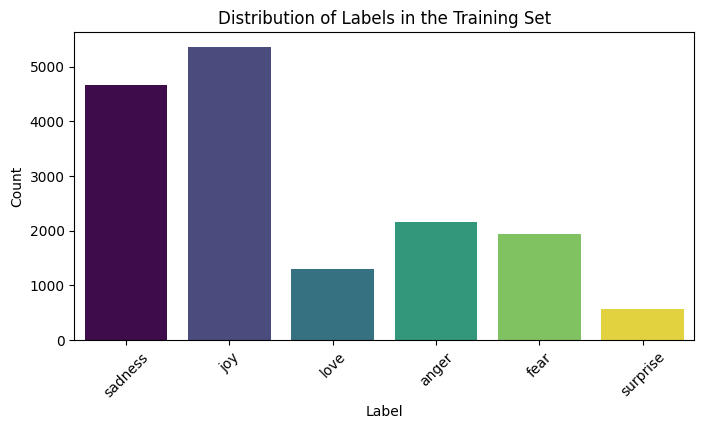

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', hue='label', data=train_df, palette='viridis', dodge=False, legend=False)
plt.title('Distribution of Labels in the Training Set')
plt.xticks(rotation=45, labels = label_names, ticks = range(len(label_names)))
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

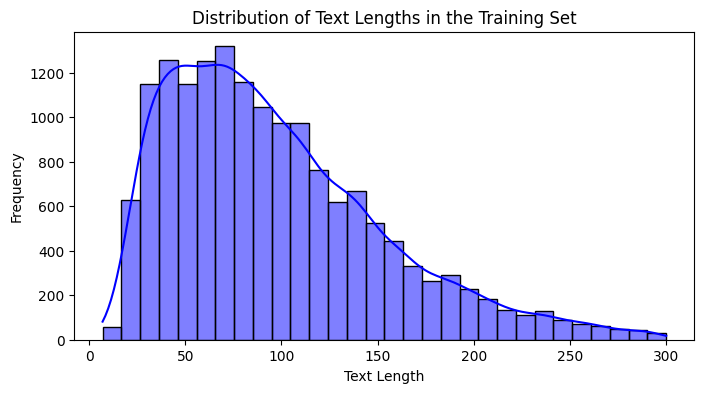

In [ ]:
train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(train_df['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Lengths in the Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


<ipython-input-11-d67b133bd0d4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='num_words', data=train_df, palette='viridis')


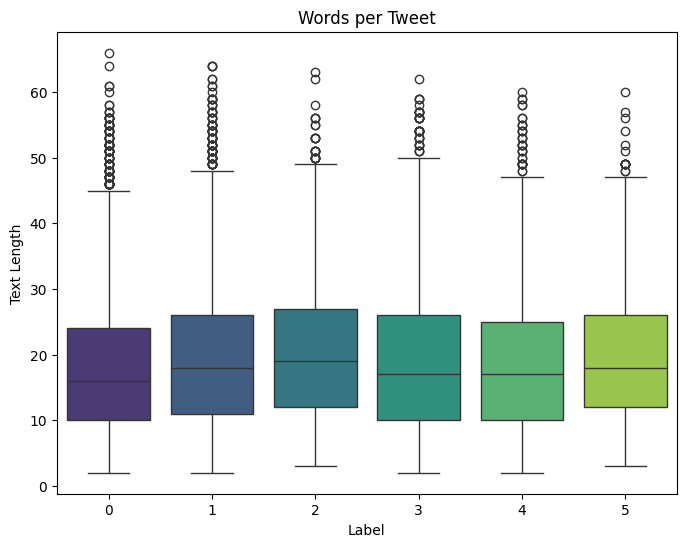

In [ ]:
train_df['num_words']= train_df["text"].str.split().apply(len)

plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='num_words', data=train_df, palette='viridis')
plt.title('Words per Tweet')
plt.xlabel('Label')
plt.ylabel('Text Length')
plt.show()


We can see that the classes are very unbalanced and the tweets have around 15 words on average.


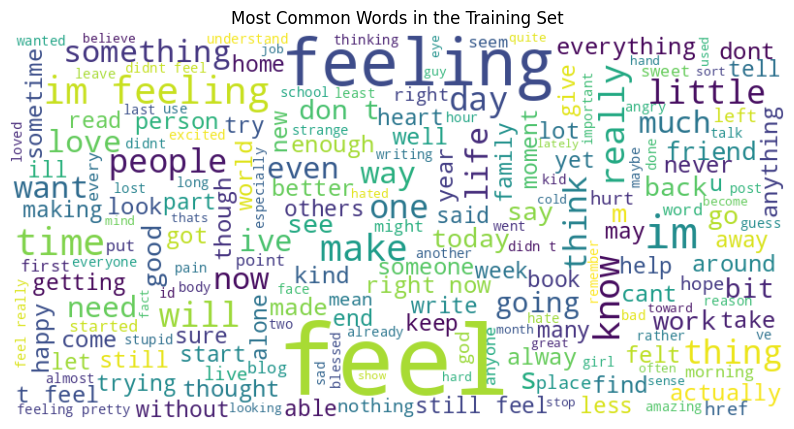

In [ ]:
all_text = ' '.join(train_df['text'])

wordcloud = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate(all_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Words in the Training Set')
plt.axis('off')
plt.show()


## Tokenizer

The DistilBERT model uses the WordPiece tokenization method. WordPiece is a subword tokenization algorithm that breaks down words into smaller pieces, allowing the model to handle a wide variety of words, including rare or unseen ones, by combining these subword units.

To tokenize the text data for DistilBERT, we use the `AutoTokenizer` class from the Hugging Face Transformers library. The `AutoTokenizer` class provides a convenient way to load a pre-trained tokenizer corresponding to any pre-trained model available in the library. By specifying the model name, we can easily initialize the appropriate tokenizer for our text classification task:


In [20]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
encoded = tokenizer(['I love my girlfriend', 'she\'s awesome!!!'], padding = True, truncation = True)
print(encoded)

{'input_ids': [[101, 1045, 2293, 2026, 6513, 102, 0, 0, 0], [101, 2016, 1005, 1055, 12476, 999, 999, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded.input_ids[0])
print(tokens)
tokens = tokenizer.convert_ids_to_tokens(encoded.input_ids[1])
print(tokens)

['[CLS]', 'i', 'love', 'my', 'girlfriend', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'she', "'", 's', 'awesome', '!', '!', '!', '[SEP]']


Let's define a function to tokenize in batch:

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
tokenize(emotions['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Now we tokenize the entire dataset:

In [20]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [ ]:
emotions_encoded['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

## Feature Extraction

One way to leverage the pre-trained model is by using its hidden states to train a classifier without modifying the pre-trained model. This approach allows us to utilize the rich representations learned by the model during pre-training. We can extract these features using the model from `AutoModel` class from the Hugging Face Transformers library.


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
inputs

Input tensor shape: torch.Size([1, 6])


{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

Now we set the device of the torch tensors and, using the pretrained model, we extract the features for this text example:

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

Note that it has 768 features for every token in the text(6 in this case), this means that for different texts we'll have a different number of features, which it is a problem to train a classical classifier, to solve this we'll just use the part associated with the [CLS] in the hidden state.
The following function extracts the features from a batch of texts.

In [ ]:
def extract_hidden_states(batch):
# Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
# Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])

In [20]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [ ]:
emotions_hidden["train"]["hidden_state"].shape

torch.Size([16000, 768])

In [ ]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Now we have the final dataset with the features extracted, so we can train a classifier such as HistGradientBoosting:

In [ ]:
hgbc = HistGradientBoostingClassifier(random_state=42, max_iter=250)
hgbc.fit(X_train, y_train)

HistGradientBoostingClassifier(max_iter=250, random_state=42)

In [ ]:
hgbc.score(X_valid, y_valid)

0.5655

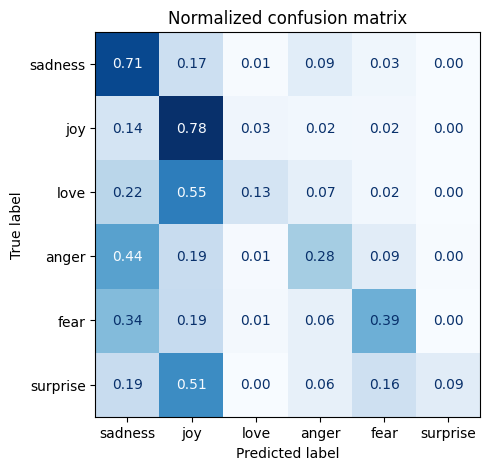

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(10, 5))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
y_preds = hgbc.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, label_names)

## Fine-Tuning

Based on the results of our initial feature extraction and classifier training, we can infer that there is a lot of room for improvement. Therefore, we will proceed with fine-tuning the DistilBERT model, which involves training the weights of the transformer as well. This approach allows us to adapt the pre-trained model more closely to our specific text classification task, potentially improving performance.
First, let's load the pretrained model e define a function to compute the metrics:

In [ ]:
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
notebook_login() #loging on hugging face to be able to log the model

Now we define the training params and start training:

In [ ]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.816800,0.275925,0.911000,0.910976
2,0.211900,0.172288,0.934000,0.934095
3,0.139100,0.157803,0.938000,0.938882
4,0.107300,0.143726,0.937500,0.937690
5,0.090100,0.144033,0.936500,0.936559


In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

{'test_loss': 0.1440327912569046,
 'test_accuracy': 0.9365,
 'test_f1': 0.9365589993256457,
 'test_runtime': 4.0662,
 'test_samples_per_second': 491.86,
 'test_steps_per_second': 7.87}

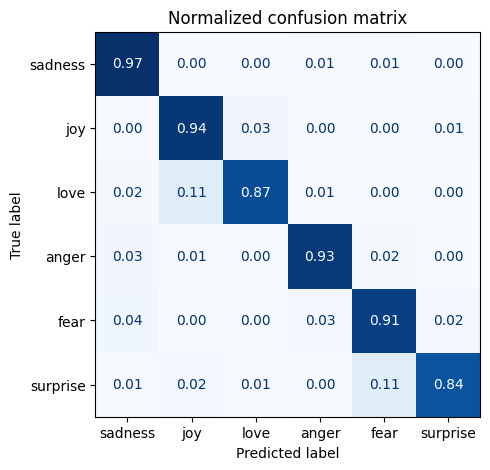

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, label_names)

## Results

The metrics improved significantly with fine-tuning, with accuracy increasing from 0.56 to 0.93! From the confusion matrix, we can see that most errors are due to the model confusing 'love' with 'joy' and 'surprise' with 'fear'.

Given that 'surprise', 'love', and 'fear' are the classes less present in the dataset, one potential improvement could be to employ techniques for handling class imbalance. Methods such as oversampling the minority classes, undersampling the majority classes, or using weighted loss functions could help the model learn to better distinguish between these less frequent classes.


## Error Analysis

The goal now is to compute the losses on the validation data to investigate the errors and identify potential issues such as wrong labels or quirks in the dataset.

By computing the losses, we can sort the validation examples by their loss values and identify the "worst" errors. This allows us to understand where the model is struggling the most and why. And maybe detect:

- **Identify Wrong Labels**: Sorting by loss helps in spotting mislabeled data, which can be corrected to improve model performance.
- **Understand Dataset Quirks**: Analyzing the highest loss examples can reveal peculiarities or patterns in the data that might be affecting the model's performance.

Through this process, we can gain insights into the types of errors the model is making and take steps to address them, thereby improving overall model accuracy.


In [ ]:
def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
    reduction="none")
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(),
  "predicted_label": pred_label.cpu().numpy()}

In [20]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
forward_pass_with_label, batched=True, batch_size=16)

In [ ]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

pd.set_option('display.max_colwidth', None) # to display the whole texts

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,surprise,sadness,6.900023
882,i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio,love,sadness,6.858221
177,im sure much of the advantage is psychological the feeling ive out clevered the competition who are now hopelessly burdened with their big chainring jump,sadness,joy,6.755349
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,joy,sadness,6.456665
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,joy,sadness,6.275760
1111,im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people,joy,fear,5.969497
1683,i had applied for a job and they had assured me that the exams would take place a few months later a week later i went to obtain some more information and they told me that the exams had already taken place,anger,joy,5.626283
1964,i feel vaguely cheated and a little amused,joy,anger,5.480209
1836,i got a very nasty electrical shock when i was tampering with some electrical applainces,fear,anger,5.101432
259,when i noticed two spiders running on the floor in different directions,anger,fear,4.895002


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
566,i did things that i always wondered about and now feel remorseful for,sadness,sadness,0.002509
69,i have no extra money im worried all of the time and i feel so beyond pathetic,sadness,sadness,0.002518
394,i feel shamed that i hoped for one last christmas because i know she would never want to live life as she is now helpless and weak,sadness,sadness,0.002518
625,i feel unwelcome in this town as if my time here has been spent my quota of memories well past brimming and my eviction notice is long overdue,sadness,sadness,0.002528
1452,i always feel guilty and come to one conclusion that stops me emily would be so disappointed in me,sadness,sadness,0.002535
11,i was dribbling on mums coffee table looking out of the window and feeling very happy,joy,joy,0.002540
1531,i forgive stanley hes not so quick to forgive as well and accuses me of making a foolish mistake and making him feel unwelcome in our apt,sadness,sadness,0.002544
1368,i started this blog with pure intentions i must confess to starting to feel a little disheartened lately by the knowledge that there doesnt seem to be anybody reading it,sadness,sadness,0.002547
452,i manage to complete the lap not too far behind the front runners and am feeling pretty jubilant until i realise that this is just the warm up,joy,joy,0.002556
1510,i feel so beaten down and defeated,sadness,sadness,0.002559


### Key Findings

- **Mislabeled Data**: The analysis revealed that the label 'joy' is sometimes mislabeled, leading to errors in the model's predictions.
- **Model Confidence**: The model is most confident about predicting the label 'sadness'. This indicates that the model has learned to identify this emotion more accurately than others.

### Next Steps

With this information, we could make targeted improvements to our dataset by correcting mislabeled data. Additionally, we should keep an eye on the 'sadness' class, which the model seems very confident about, to ensure this confidence is justified and not due to any bias in the data.

### Saving the Model

The last step before serving the trained model is to save it for later usage. This ensures that the fine-tuned model can be easily deployed and used for inference on new data:


In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

## Loading the Model and Making Predictions

Next, we will load the model from Hugging Face and make predictions using the `pipeline` from the Transformers library. This allows us to leverage the fine-tuned model for inference on new data efficiently and effectively.


In [20]:
model_id = "kairosilveira/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [18]:
custom_tweet = "Katia is a lovely girlfriend! <3"
preds = classifier(custom_tweet, return_all_scores=True)

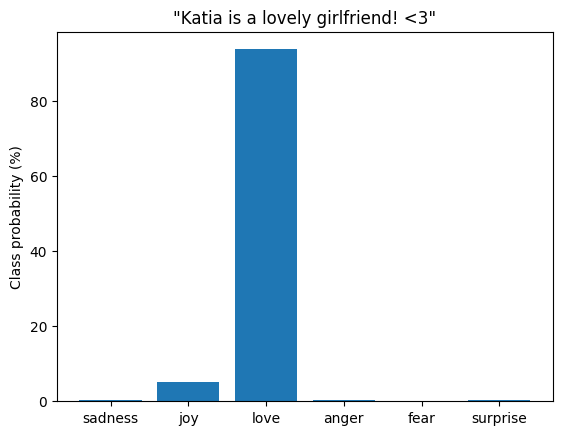

In [19]:
preds_df = pd.DataFrame(preds[0])
plt.bar(label_names, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion

This project successfully demonstrated text classification using a fine-tuned DistilBERT model from the Hugging Face Transformers library. Through exploratory data analysis, feature extraction, and model fine-tuning, we achieved significant improvements in accuracy.

In a business scenario, the next steps could be:

- **Further Error Analysis**: Continue refining the dataset by addressing mislabeled instances and ensuring balanced class distribution.
- **Model Optimization**: Experiment with different model architectures, hyperparameters, and training strategies to further enhance performance.
- **Deployment**: Implement the trained model in a production environment and monitor its performance on live data.
- **User Feedback**: Incorporate user feedback to continually improve the model's predictions and address any emerging issues.

This concludes the text classification project. Future development will focus on refining the model, enhancing its robustness, and ensuring its applicability in real-world scenarios.
